In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams["figure.figsize"] = (20, 9)

In [73]:
def inch_to_m(inch):
    # 1″ = 0.0254 m
    return inch * 0.0254

def cm_to_m(cm):
    # 1 cm = 0.01 m
    return cm * 0.01

def lbs_to_kg(lbs):
    # 1 pound [lbs] = 0.45359237 kilogram [kg]
    return lbs * 0.45359237

def calc_BMI(weight, height):
    # BMI = kg/m^2
    return weight / height**2

def classify_BMI_2(bmi):
    classes = ["healthy", "unhealthy"]
    if bmi < 25.0:
        return 0 # classes[0]
    elif bmi >= 25.0:
        return 1 # classes[1]
    else:
        return -1 # "No categories"

def classify_BMI_4(bmi):
    classes = ["underweight", "normal", "overweight", "obese"]
    if bmi < 18.5:
        return 0 # classes[0]
    elif (bmi >= 18.5) & (bmi < 25.0):
        return 1 # classes[1]
    elif (bmi >= 25.0) & (bmi < 30.0):
        return 2 # classes[2]
    elif bmi > 30.0:
        return 3 # classes[3]
    else:
        return -1 # "No categories"

- Content
- The variables listed below, from left to right, are:
    -   Density determined from underwater weighing
    -   Percent body fat from Siri's (1956) equation
    -   Age (years)
    -   Weight (lbs)
    -   Height (inches)
    -   Neck circumference (cm)
    -   Chest circumference (cm)
    -   Abdomen 2 circumference (cm)
    -   Hip circumference (cm)
    -   Thigh circumference (cm)
    -   Knee circumference (cm)
    -   Ankle circumference (cm)
    -   Biceps (extended) circumference (cm)
    -   Forearm circumference (cm)
    -   Wrist circumference (cm)

In [74]:
dataset_address = "../datasets/kaggle/body-fat/"
filename = "bodyfat.csv"
df = pd.read_csv(dataset_address+filename, sep=",")
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


- Convert the units and add new features
- Add BMI Classification based on https://www.cdc.gov/obesity/basics/adult-defining.html#:~:text=Adult%20Body%20Mass%20Index&text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.

    - Underweight:      < 18.5
    - Normal:           >= 18.5 & < 25.0
    - Overweight:       >= 25.0 & < 30.0
    - Obese:            >= 30.0


In [75]:

df["Weight"] = df["Weight"].apply(func=lbs_to_kg).values
df["Height"] = df["Height"].apply(func=inch_to_m).values
df.loc[:, "Neck":"Wrist"] = df.loc[:, "Neck":"Wrist"].apply(func=cm_to_m).values
df["BMI"] = calc_BMI(df["Weight"].values, df["Height"].values)
df["BMI_cat_2"] = df["BMI"].apply(func=classify_BMI_2).values
df["BMI_cat_4"] = df["BMI"].apply(func=classify_BMI_4).values

# one_hot_encoding = pd.get_dummies(df["BMI_cat"], prefix="BMI_", drop_first=False)
# df.join(one_hot_encoding)


In [76]:
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI,BMI_cat_2,BMI_cat_4
0,1.0708,12.3,23,69.966623,1.72085,0.362,0.931,0.852,0.945,0.590,0.373,0.219,0.320,0.274,0.171,23.626799,0,1
1,1.0853,6.1,22,78.584878,1.83515,0.385,0.936,0.830,0.987,0.587,0.373,0.234,0.305,0.289,0.182,23.334358,0,1
2,1.0414,25.3,22,69.853225,1.68275,0.340,0.958,0.879,0.992,0.596,0.389,0.240,0.288,0.252,0.166,24.668757,0,1
3,1.0751,10.4,26,83.801190,1.83515,0.374,1.018,0.864,1.012,0.601,0.373,0.228,0.324,0.294,0.182,24.883247,0,1
4,1.0340,28.7,24,83.574394,1.80975,0.344,0.973,1.000,1.019,0.632,0.422,0.240,0.322,0.277,0.177,25.517379,1,2


In [77]:
df.columns

Index(['Density', 'BodyFat', 'Age', 'Weight', 'Height', 'Neck', 'Chest',
       'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm',
       'Wrist', 'BMI', 'BMI_cat_2', 'BMI_cat_4'],
      dtype='object')

In [78]:
cols = df.columns[0: 15].to_list() 
# sns.pairplot(df.loc[:, cols+["BMI_cat_4"]], hue="BMI_cat_4")
# plt.show();

In [79]:
cols_X = ["Density", "BodyFat", "Age"]
cols_y = ["BMI_cat_4"]
data_X = df.loc[:, cols_X].values
data_X = MinMaxScaler().fit_transform(data_X)
data_y = df.loc[:, cols_y].values.flatten()

In [80]:
# specify sizes of the partitions
# order is train, dev, test
partitions = [.75, .10, .15]

# split the data (note the third input, and the TMP in the variable name)
train_data, testdev_data, train_labels, testdev_label = train_test_split(data_X, data_y, train_size=partitions[0])

# now split the testdev_data
split = partitions[1] / np.sum(partitions[1:])
dev_data, test_data, dev_labels, test_labels = train_test_split(testdev_data, testdev_label, train_size=split)

# Convert to PyTorch Datasets
train_dataset = TensorDataset(torch.Tensor(train_data).float(), torch.Tensor(train_labels).long())
dev_dataset = TensorDataset(torch.Tensor(dev_data).float(), torch.Tensor(dev_labels).long())
test_dataset = TensorDataset(torch.Tensor(test_data).float(),torch.Tensor(test_labels).long())

# Convert to PyTorch DataLoader and apply batchting
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=dev_dataset.tensors[0].shape[0])
test_loader  = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [81]:
train_dataset.tensors[0].shape[0] // 20

9

In [82]:
def create_model(n_input=1, n_output=1, lr=.01):
    model = nn.Sequential(
        nn.Linear(n_input, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_input*20),
        nn.ReLU(),
        nn.Linear(n_input*20, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_output),
        # nn.Softmax(dim=1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

def train_model(train_loader, dev_loader, model=None, loss_func=nn.CrossEntropyLoss(), optimizer=None, n_epochs=1, plot_history=False):
    # X = torch.Tensor(X).float()
    # y = torch.Tensor(y).long()
    # X_dev = torch.Tensor(X_dev).float()
    # y_dev = torch.Tensor(y_dev).long()
    
    losses = torch.zeros(n_epochs)
    accs = torch.zeros(n_epochs)
    losses_dev = torch.zeros(n_epochs)
    accs_dev = torch.zeros(n_epochs)

    ## Train the model!
    for i in range(n_epochs):
        
        # loop over training data batches        
        batch_loss = []
        batch_acc = []
        for X, y in train_loader:

            # forward pass
            preds = model(X)
            
            # compute loss (trainset)
            loss = loss_func(preds, y)
            batch_loss.append(loss.item())
            
            # compute accuracy (trainset) for this batch
            acc = 100*torch.mean((torch.argmax(preds, axis=1) == y).float())
            batch_acc.append(acc.item())
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses[i] = np.mean(batch_loss)
        accs[i] = np.mean(batch_acc)

        # forward pass (devset)
        X_dev, y_dev = next(iter(dev_loader))
        preds_dev = model(X_dev)
        
        # compute loss (devset)
        loss_dev = loss_func(preds_dev, y_dev)
        losses_dev[i] = loss_dev
        
        # compute accuracy (devset)
        acc_dev = 100*torch.mean((torch.argmax(preds_dev, axis=1) == y_dev).float()) 
        accs_dev[i] = acc_dev
    
    # final forward pass (trainset)
    X, y = next(iter(train_loader))
    predictions = model(X)
    total_acc = 100*torch.mean((torch.argmax(predictions, axis=1) == y).float())
    
    # final forward pass (dev)
    X_dev, y_dev = next(iter(dev_loader))
    predictions_dev = model(X_dev)
    total_acc_dev = 100*torch.mean((torch.argmax(predictions_dev, axis=1) == y_dev).float())

    if plot_history:
        _, axes = plt.subplots(1, 2)

        axes[0].plot(losses.detach(), label="Loss (trainset)")
        axes[0].plot(losses_dev.detach(), label="Loss (devset)")
        axes[0].set_ylabel("Loss")
        axes[0].set_xlabel("Epochs")
        axes[0].set_title(f"Final Loss (trainset): {loss.detach():.4f}\nFinal Loss (devset): {loss_dev.detach():.4f}")
        axes[0].legend()

        axes[1].plot(accs.detach(), label="Accuracy (trainset)")
        axes[1].plot(accs_dev.detach(), label="Accuracy (devset)")
        axes[1].set_ylabel("Accuracy")
        axes[1].set_xlabel("Epochs")
        axes[1].set_title(f"Final Accuracy (trainset): {total_acc.detach():.2f} %\nTotal Accuracy (devset): {total_acc_dev.detach():.2f} %")
        axes[1].legend()
        
        plt.show()
    return accs, losses, accs_dev, losses_dev

def evaluate_model(test_loader, model, loss_func=nn.CrossEntropyLoss(), label_names=["X1", "X2"]):

    # manually compute losses
    # final forward pass
    X, y = next(iter(test_loader))
    predictions = model(X)
    
    # compute Loss
    loss = loss_func(predictions, y)
    # compute accuracy
    acc = 100*torch.mean((torch.argmax(predictions, axis=1) == y).float())
    
    softmax = nn.Softmax(dim=1)    
    plt.plot(softmax(predictions.detach()), "o")                # with Softmax activation
    # plt.plot(predictions.detach(), "s-", markerfacecolor="w") # without Softmax activation
    plt.xlabel("Stimulus number")
    plt.ylabel("Probability")
    plt.legend(label_names)
    plt.title(f"Accuracy (testset): {acc.detach():.2f} %\nLoss (testset): {loss.detach():.4f}")
    plt.show()

    return acc, loss, predictions

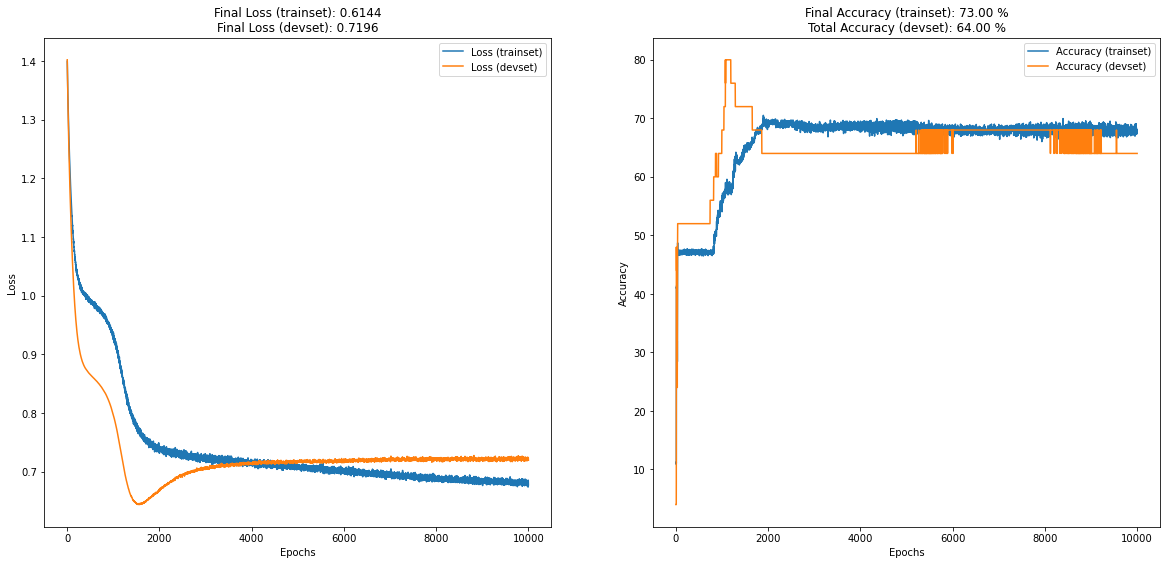

In [83]:
model, optimizer = create_model(n_input=len(cols_X), n_output=len(np.unique(data_y)), lr=.01)
history = train_model(
    train_loader=train_loader, dev_loader=dev_loader,
    model=model, loss_func=nn.CrossEntropyLoss(), optimizer=optimizer, n_epochs=10000,
    plot_history=True
)

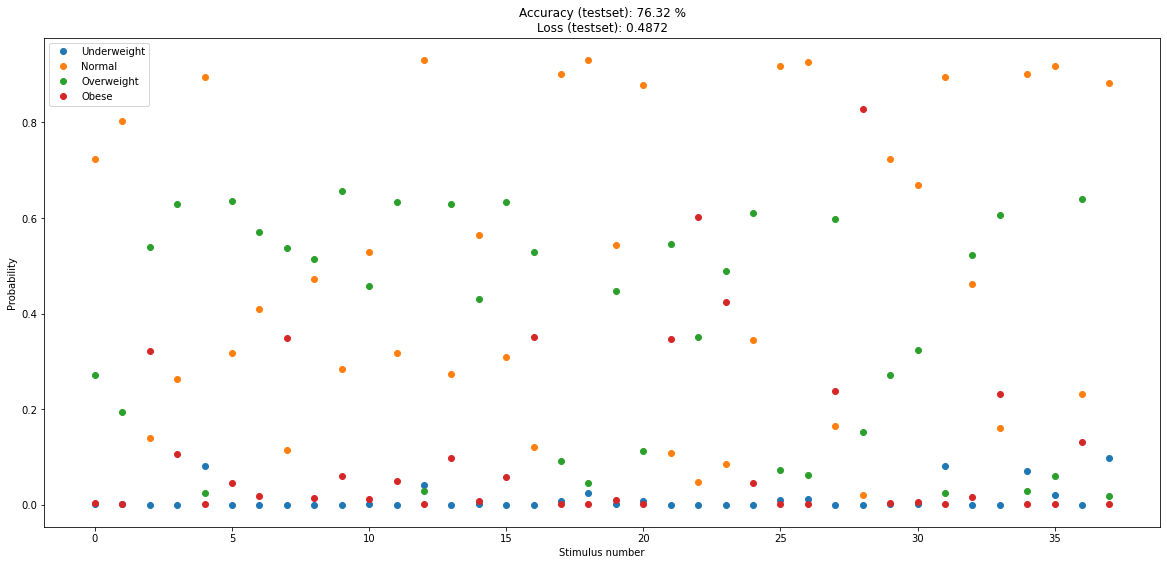

Test Accuracy: 76.32%
Test Loss: 0.4872


In [84]:
acc, loss, pred = evaluate_model(test_loader=test_loader, model=model, label_names=["Underweight", "Normal", "Overweight", "Obese"])
print(f"Test Accuracy: {acc:.2f}%")
print(f"Test Loss: {loss:.4f}")